# Approximating KL divergence


## [PPO]
$$
r_t = r_{\varphi}(q, o_{\leq t}) - \beta \log \frac{\pi_{\theta}(o_t \mid q, o_{<t})}{\pi_{\text{ref}}(o_t \mid q, o_{<t})},
$$
where $r_{\varphi}$ is the reward model, $\pi_{\text{ref}}$ is the reference model, which is usually the initial SFT model, and $\beta$ is the coefficient of the KL penalty.

## [GRPO]

And different from the KL penalty term used in (2), we estimate the KL divergence with the following unbiased estimator (Schulman, 2020):

$$
\mathbb{D}_{KL} \left[ \pi_{\theta} \| \pi_{\text{ref}} \right] = \frac{\pi_{\text{ref}}(o_{i,t} \mid q, o_{i,<t})}{\pi_{\theta}(o_{i,t} \mid q, o_{i,<t})} - \log \frac{\pi_{\text{ref}}(o_{i,t} \mid q, o_{i,<t})}{\pi_{\theta}(o_{i,t} \mid q, o_{i,<t})} - 1,
$$

which is guaranteed to be positive.

**不同于PPO，GRPO对KL散度的估计使用的是 Reverse KL Div**

## 概念与基本定义

- KL 散度（Kullback–Leibler divergence），也叫相对熵（relative entropy），  
用于衡量两个概率分布 \(P\)（真实分布）和 \(Q\)（近似分布）之间的信息差异。对离散分布：

$$
D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}.
$$

- 对连续分布（假设密度存在）：

$$
D_{KL}(P \| Q) = \int p(x) \log \frac{p(x)}{q(x)} \, dx.
$$

- 重要性质
    - 非负性：$D_{KL}(P \| Q) \geq 0$，且当且仅当 $P = Q$（几乎处处）时等号成立（Gibbs 不等式）。
    - 不对称：一般 $D_{KL}(P \| Q) \neq D_{KL}(Q \| P)$。
    - 不满足三角不等式——不是距离(metric)。
    - 与信息量关系：$D_{KL}(P \| Q) = \mathbb{E}_P[\log p(X)] - \mathbb{E}_P[\log q(X)]$：即平均对数似然差。

## KL div 的估计
由于在实践中很难对KL散度进行准确的解析，尝试用估计的方法进行近似。
- Monte Carlo 重要性采样：
    - 对于 p 分布（目标分布） 和 q 分布（采样分布）
    - $(x_i) ~ p $ 从q分布采样得到样本，且服从某一分布(岩本充足正态分布)
    - 定义重要性权重 $r = \frac{p(x)}{q(x)} $
    - foward KL div: $$\text{KL}[q \| p] = \mathbb{E}_{x \sim q} \left[ \log \frac{q(x)}{p(x)} \right] = \mathbb{E}_{x \sim q}[-\log r]$$
        - {Mean-seeking} or {mass-covering}：约束 / 最小化目标促使 \(q\) 尽可能地覆盖真实分布 \(p\) 的所有高概率区域，  
        即使这意味着 \(q\) 也在 \(p\) 的低概率区有一些质量，或者 \(Q\) 会把峰之间的区域也包含（即覆盖间隙）。这更像是 forward KL 的行为。

    - reverse KL div: $$\text{KL}[p \| q] = \mathbb{E}_{x \sim p} \left[ \log \frac{p(x)}{q(x)} \right]$$
        - {Mode-seeking} or {zero-forcing}：约束或最小化目标会促使近似分布 \(q\) 将质量集中在一个或几个高密度的峰/模态上，而忽视其他低概率/远离峰的模态。  
        这正是 reverse KL 的行为，因为 reverse KL 惩罚 \(q\) 在 \(p\) 显著低密度处放很多质量的情况。

## Approximating KL Divergence
[参考：Approximating KL Divergence (by John Schulman's)](http://joschu.net/blog/kl-approx.html)

采用上面的记号：对于 p 分布（目标分布） 和 q 分布（采样分布），定义重要性权重 $r = \frac{p(x)}{q(x)} $
1. $k_1 = -\log r$
   - 这是 $D_{KL}[q \| p]$ 的**无偏估计量**，因为 $\mathbb{E}_{x \sim q}[k_1] = \mathbb{E}_{x \sim q}[-\log r] = D_{KL}[q \| p]$。
   - 方差：$\text{Var}[k_1] = \text{Var}[\log r]$，**可能较高**如果 $r$ 偏离 1 较远。

2. $k_2 = 0.5(\log r)^2$
   - 这**不是** KL 散度的无偏估计量。其期望值 $\mathbb{E}_{x \sim q}[k_2] = 0.5 \mathbb{E}_{x \sim q}[(\log r)^2]$ 是 $\log r$ 的二阶矩，而不是 KL 散度。
   - 当 $r$ 接近 1 时，$k_2$ 近似于 $D_{KL}[q \| p]$，因为通过泰勒展开有 $\log r \approx r - 1$ 和 $0.5(\log r)^2 \approx 0.5(r - 1)^2$，而 $D_{KL}[q \| p] \approx 0.5\mathbb{E}[(r - 1)^2]$。
   - 优点是方差比较小

3. $k_3 = (r - 1) - \log r$
   - 这是 $D_{KL}[q \| p]$ 的无偏估计量，因为 $\mathbb{E}_{x \sim q}[k_3] = \mathbb{E}_{x \sim q}[(r - 1) - \log r] = \mathbb{E}_{x \sim q}[r - 1] - \mathbb{E}_{x \sim q}[\log r] = 0 - (-D_{KL}[q \| p]) = D_{KL}[q \| p]$（其中 $\mathbb{E}[r] = 1$）。
   - 由 $k_2$ 改进，**继承了方差比较小的特点，并且还有一个无偏优势，是一个好的估计器。**

对应的：

- `PPO`$\mathrm{k_1}[p, q]$
- `GRPO`$\mathrm{k_3}[q, p]$

In [ ]:
import torch.distributions as dis
p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=1)
x = q.sample(sample_shape=(10_000_000,))
truekl = dis.kl_divergence(p, q)
print("true", truekl)
logr = p.log_prob(x) - q.log_prob(x)
k1 = -logr
k2 = logr ** 2 / 2
k3 = (logr.exp() - 1) - logr
for k in (k1, k2, k3):
    print(k, (k.mean() - truekl) / truekl, k.std() / truekl)

true tensor(0.0050)
tensor(-0.0016) tensor(19.9961)
tensor(0.0021) tensor(1.4159)
tensor(-0.0004) tensor(1.4147)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.distributions import Normal, MixtureSameFamily, Independent, Categorical

In [15]:
torch.manual_seed(42)
np.random.seed(42)

In [16]:
# 目标分布 P：混合高斯
class MixtureGaussian:
    def __init__(self, mu=2.0, sigma=1.0, mix_ratio=0.5):
        self.mu = mu
        self.sigma = sigma
        self.mix_ratio = mix_ratio
        
        # component 参数组织成 tensors，最后一个维度是组件数 2
        # locs 和 scales 的 shape: [num_components]
        locs = torch.tensor([-mu, +mu], dtype=torch.float32)
        scales = torch.tensor([sigma, sigma], dtype=torch.float32)
        
        # component distribution
        # 对于每一个 component 使用 Normal(loc, scale)
        # 使用 Independent 封装事件维度，如果需要（一维一般不需要）
        comp = Normal(locs, scales)  # batch_shape = [2], event_shape = []  (标量)
        
        # mixture 权重
        mix_probs = torch.tensor([mix_ratio, 1.0 - mix_ratio], dtype=torch.float32)
        mix = Categorical(mix_probs)
        
        # 最终的混合分布
        self.mixture = MixtureSameFamily(mix, comp)
    
    def log_prob(self, x):
        # x 可以是 Tensor of shape [batch_size]
        return self.mixture.log_prob(x)
    
    def sample(self, n):
        return self.mixture.sample((n,))  # shape [n]

# 近似分布 Q：可训练的单一 Gaussian
class ApproxGaussian(nn.Module):
    def __init__(self, init_mu=0.0, init_log_sigma=0.0):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor(init_mu, dtype=torch.float32))
        self.log_sigma = nn.Parameter(torch.tensor(init_log_sigma, dtype=torch.float32))
    
    def log_prob(self, x):
        sigma = torch.exp(self.log_sigma)
        # Normal 的 log_prob 支持 batch
        return Normal(self.mu, sigma).log_prob(x)
    
    def sample(self, n):
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * torch.randn(n, dtype=torch.float32)

In [17]:
# 实验设置
P = MixtureGaussian(mu=5.0, sigma=1.0, mix_ratio=0.8)
Q_forward = ApproxGaussian(init_mu=-3.0, init_log_sigma=np.log(2.0))
Q_reverse = ApproxGaussian(init_mu=-3.0, init_log_sigma=np.log(2.0))

lr = 0.05
optimizer_f = optim.Adam(Q_forward.parameters(), lr=lr)
optimizer_r = optim.Adam(Q_reverse.parameters(), lr=lr)

epochs = 2000
batch_size = 1024

traj_forward = []
traj_reverse = []

for epoch in range(epochs):
    # Forward KL
    x_p = P.sample(batch_size)
    log_p = P.log_prob(x_p)
    log_q_f = Q_forward.log_prob(x_p)
    loss_f = torch.mean(log_p - log_q_f)  # 有常数但我们关心相对量
    optimizer_f.zero_grad()
    loss_f.backward()
    optimizer_f.step()
    with torch.no_grad():
        traj_forward.append((Q_forward.mu.item(), torch.exp(Q_forward.log_sigma).item()))
    
    # Reverse KL
    x_q = Q_reverse.sample(batch_size)
    log_q_r = Q_reverse.log_prob(x_q)
    log_p_at_q = P.log_prob(x_q)
    loss_r = torch.mean(log_q_r - log_p_at_q)
    optimizer_r.zero_grad()
    loss_r.backward()
    optimizer_r.step()
    with torch.no_grad():
        traj_reverse.append((Q_reverse.mu.item(), torch.exp(Q_reverse.log_sigma).item()))


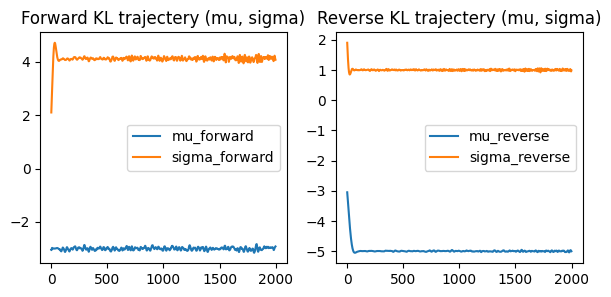

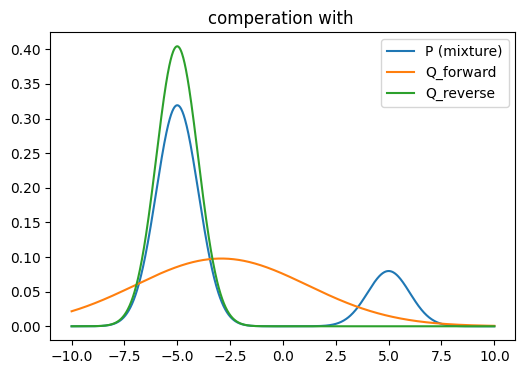

In [20]:
# 可视化轨迹
traj_forward = np.array(traj_forward)  # shape (epochs, 2)
traj_reverse = np.array(traj_reverse)

fig, axes = plt.subplots(1, 2, figsize=(7,3))
axes[0].plot(traj_forward[:,0], label='mu_forward')
axes[0].plot(traj_forward[:,1], label='sigma_forward')
axes[0].set_title('Forward KL trajectery (mu, sigma)')
axes[0].legend()

axes[1].plot(traj_reverse[:,0], label='mu_reverse')
axes[1].plot(traj_reverse[:,1], label='sigma_reverse')
axes[1].set_title('Reverse KL trajectery (mu, sigma)')
axes[1].legend()

plt.show()

# 最终密度对比
xs = np.linspace(-10, 10, 1000, dtype=np.float32)
with torch.no_grad():
    xs_tensor = torch.tensor(xs)
    p_x = torch.exp(P.log_prob(xs_tensor))
    qf_x = torch.exp(Q_forward.log_prob(xs_tensor))
    qr_x = torch.exp(Q_reverse.log_prob(xs_tensor))

plt.figure(figsize=(6,4))
plt.plot(xs, p_x.numpy(), label='P (mixture)')
plt.plot(xs, qf_x.numpy(), label='Q_forward')
plt.plot(xs, qr_x.numpy(), label='Q_reverse')
plt.title('comperation with ')
plt.legend()
plt.show()